# Classify text with BERT

### Learning Objectives
1. Learn how to load a pre-trained BERT model from TensorFlow Hub
2. Learn how to build your own model by combining with a classifier
3. Learn how to train a BERT model by fine-tuning
4. Learn how to save your trained model and use it
5. Learn how to evaluate a text classification model

This lab will show you how to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.



## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


# Create a New Conda Environment

1. If you haven't already created a CUDA enabled environment then go to https://www.youtube.com/watch?v=jZsopVyJktc and make sure you have one set up
2. Create a clone of the CUDA environment for our use by going to the Anaconda prompt and typing
```bash
conda create --name your_env_name --clone tf_gpu
```
2. Make sure use the new environment for this notebook.
3. Enjoy the code! :)

### Install the packages we need

NOTE: when you try to run any cell you will be prompted to install ipykernel. Make sure to install it as prompted. 

In [1]:
! pip install tf-models-official
! pip install maplotlib


  Using cached tf_models_official-2.17.0-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached Cython-3.0.11-cp39-cp39-win_amd64.whl.metadata (3.2 kB)
  Using cached pillow-10.4.0-cp39-cp39-win_amd64.whl.metadata (9.3 kB)
  Using cached gin_config-0.5.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached google_api_python_client-2.143.0-py2.py3-none-any.whl.metadata (6.7 kB)
  Using cached immutabledict-4.2.0-py3-none-any.whl.metadata (3.4 kB)
  Using cached kaggle-1.6.17-py3-none-any.whl
  Using cached matplotlib-3.9.2-cp39-cp39-win_amd64.whl.metadata (11 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached pandas-2.2.2-cp39-cp39-win_amd64.whl.metadata (19 kB)
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached pycocotools-2.0.8-cp39-cp39-win_amd64.whl.metadata (1.1 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-win_amd64.whl.metadat

ERROR: Could not find a version that satisfies the requirement maplotlib (from versions: none)
ERROR: No matching distribution found for maplotlib


In [24]:
import os  # Provides a way of using operating system dependent functionality
import warnings  # Used to handle warnings in the code

# Ignore all warnings
warnings.filterwarnings("ignore")

import datetime  # Import datetime module to work with dates and times
import shutil  # High-level file operations such as copying and removal of files

import matplotlib.pyplot as plt  # Matplotlib plotting library for creating static, animated, and interactive visualizations

import tensorflow as tf  # Core TensorFlow library for machine learning and neural networks
import tensorflow_hub as hub  # TensorFlow Hub is a library for reusable machine learning modules
import tensorflow_text as text  # TensorFlow Text provides text-based operations for TensorFlow
import tensorflow_addons as tfa  # A collection of additional functionality not available in TensorFlow core



In [4]:
# Set TensorFlow logger level to only display errors
tf.get_logger().setLevel("ERROR")

# Set TensorFlow C++ logging level to reduce output
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Update PATH to include the directory containing saved_model_cli if necessary
# Adjust the anaconda_path based on your local Anaconda environment setup
anaconda_path = os.path.expanduser("~/anaconda3/envs/glabs/bin")
os.environ["PATH"] = f"{anaconda_path}:{os.environ['PATH']}"


### CUDA Support

to check if you have a GPU attached. Run the following.

NOTE: You will absolutely need to have at least one GPU recognized by TensorFlow or the training can take hours instead of minutes. 

In [5]:
# Print the number of available GPUs for TensorFlow
print("Num GPUs Available:", len(tf.config.list_physical_devices("GPU")))


Num GPUs Available: 1


### Sentiment Analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [6]:
# URL for the IMDB dataset (for sentiment analysis)
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Set path to the Downloads folder on Windows
# NOTE: You need to create the 'tfds_datasets' folder in your Downloads folder
path = os.path.join(os.path.expanduser("~"), "Downloads", "tfds_datasets")

# Ensure the directory exists, create it if it doesn't
os.makedirs(path, exist_ok=True)

# Define the expected dataset directory and file paths
dataset_dir = os.path.join(path, "aclImdb")
train_dir = os.path.join(dataset_dir, "train")
dataset_file = os.path.join(path, "aclImdb_v1.tar.gz")

# Check if the training data directory already exists
if not os.path.exists(train_dir):
    if not os.path.exists(dataset_file):
        # Download and extract the dataset if not already downloaded
        dataset = tf.keras.utils.get_file(
            "aclImdb_v1.tar.gz", url, 
            untar=True, 
            cache_dir=path, 
            cache_subdir=""
        )
    else:
        # Extract the dataset if it has been downloaded but not extracted
        dataset = tf.keras.utils.get_file(
            "aclImdb_v1.tar.gz", url, 
            untar=True, 
            cache_dir=path, 
            cache_subdir=""
        )

    # Remove unused folders (e.g., 'unsup') to simplify the dataset structure
    remove_dir = os.path.join(train_dir, "unsup")
    if os.path.exists(remove_dir):
        shutil.rmtree(remove_dir)

    print(f"Dataset downloaded and extracted to: {dataset_dir}")
else:
    print(f"Dataset already exists at: {dataset_dir}")

# Print the path to the training data directory
print(f"Training data directory: {train_dir}")


Dataset already exists at: C:\Users\Zain_\Downloads\tfds_datasets\aclImdb
Training data directory: C:\Users\Zain_\Downloads\tfds_datasets\aclImdb\train


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [7]:
# Set TensorFlow data pipeline options
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32  # Number of samples per gradient update
seed = 42  # Random seed for reproducibility

# Use the path from the previous cell for the dataset location
path = os.path.join(os.path.expanduser("~"), "Downloads", "tfds_datasets")

# Function to create a dataset from a directory
def create_dataset(directory, validation_split=None, subset=None):
    return tf.keras.preprocessing.text_dataset_from_directory(
        directory,
        batch_size=batch_size,
        validation_split=validation_split,
        subset=subset,
        seed=seed,
    )

# Create the training dataset, using 80% of the data for training
raw_train_ds = create_dataset(
    os.path.join(path, "aclImdb", "train"),
    validation_split=0.2,  # Use 20% of the data for validation
    subset="training"
)

# Get the class names (e.g., positive, negative) from the dataset
class_names = raw_train_ds.class_names

# Cache the training dataset and prefetch it for performance optimization
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the validation dataset, using the remaining 20% of the data
val_ds = create_dataset(
    os.path.join(path, "aclImdb", "train"),
    validation_split=0.2,
    subset="validation"
)

# Cache the validation dataset and prefetch it for performance optimization
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Create the test dataset from the test directory
test_ds = create_dataset(os.path.join(path, "aclImdb", "test"))

# Cache the test dataset and prefetch it for performance optimization
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Print information about the datasets
print("Datasets created successfully.")
print(f"Class names: {class_names}")
print(f"Number of training batches: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.
Datasets created successfully.
Class names: ['neg', 'pos']
Number of training batches: 625
Number of validation batches: 157
Number of test batches: 782


Let's take a look at a few reviews.

In [8]:
# Iterate through a batch of training data
for text_batch, label_batch in train_ds.take(1):
    # Display the first 3 reviews and their corresponding labels
    for i in range(3):
        # Print the review text
        print(f"Review: {text_batch.numpy()[i]}")
        
        # Get the label (0 or 1) and print the corresponding class name
        label = label_batch.numpy()[i]
        print(f"Label : {label} ({class_names[label]})")
        
        # Print a separator line for better readability
        print("-" * 80)


Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
--------------------------------------------------------------------------------
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and i

## Loading models from TensorFlow Hub

For the purpose of this lab, we will be loading a model called Small BERT. Small BERT has the same general architecture as the original BERT but the has fewer and/or smaller Transformer blocks. 

Some other popular BERT models are BERT Base, ALBERT, BERT Experts, Electra. See the continued learning section at the end of this lab for more info. 

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/tutorials/text/solve_glue_tasks_using_bert_on_tpu).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

### Choose a BERT model to fine-tune

In [9]:
# TensorFlow Hub URLs for the BERT encoder and preprocessing models
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

# Print the selected BERT model and preprocessing model URLs
print(f"BERT model selected           : {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

# Verify that the models can be loaded from TensorFlow Hub
try:
    bert_model = hub.load(tfhub_handle_encoder)  # Load the BERT model
    preprocess_model = hub.load(tfhub_handle_preprocess)  # Load the preprocessing model
    print("Models loaded successfully!")
except Exception as e:
    # Handle errors during model loading, such as network issues
    print(f"An error occurred while loading the models: {e}")
    print("Please check your internet connection and TensorFlow Hub installation.")


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3
Models loaded successfully!


## Preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

Use `hub.KerasLayer` to initialize the preprocessing

In [10]:
# Define the URL for the BERT preprocessing model from TensorFlow Hub
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

try:
    # Attempt to create the KerasLayer for the BERT preprocessing model
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    
    print("BERT preprocessing layer created successfully!")
    
    # Optional: Test the preprocessing layer with a sample input
    text_test = ['This is a test sentence.']
    text_preprocessed = bert_preprocess_model(text_test)
    
    print("Sample preprocessing output:")
    # Print the shapes of the preprocessed output tensors
    for key, value in text_preprocessed.items():
        print(f"{key}: shape = {value.shape}")

except Exception as e:
    # Handle errors during the creation of the preprocessing layer
    print(f"An error occurred while creating the preprocessing layer: {e}")
    print("Please check your internet connection and TensorFlow Hub installation.")


BERT preprocessing layer created successfully!
Sample preprocessing output:
input_type_ids: shape = (1, 128)
input_mask: shape = (1, 128)
input_word_ids: shape = (1, 128)


Let's try the preprocessing model on some text and see the output:

Call the preprocess model function and pass text_test

In [11]:
# Sample input text for testing the BERT preprocessing model
text_test = ["this is such an amazing movie!"]

# Apply the BERT preprocessing model to the sample text
text_preprocessed = bert_preprocess_model(text_test)

# Print the keys of the dictionary returned by the preprocessing model
print(f"Keys       : {list(text_preprocessed.keys())}")

# 1. input_word_ids are the token IDs corresponding to the words in the tokenized sentence
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')

# 2. input_mask indicates which tokens should be masked (used in masked language models)
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')

# 3. input_type_ids represent the sentence ID for the input sentence
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. 
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

The text pre-processor is a TensorFlow model. This means that instead of pre-processing separately, we can include it as a layer in the model code.

### Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [12]:
# URL for the BERT encoder model from TensorFlow Hub
tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

try:
    # Create the KerasLayer for the BERT encoder model
    bert_model = hub.KerasLayer(
        tfhub_handle_encoder, 
        trainable=True,  # Allow the model to be fine-tuned during training
        name='BERT_encoder'
    )
    
    print("BERT encoder layer created successfully!")

except Exception as e:
    # Handle any errors that occur during the creation of the BERT encoder layer
    print(f"An error occurred: {e}")
    print("Please check your internet connection and TensorFlow Hub installation.")


BERT encoder layer created successfully!


In [13]:
# Pass the preprocessed text through the BERT model
bert_results = bert_model(text_preprocessed)

# Print the BERT model information and results
print(f"Loaded BERT: {tfhub_handle_encoder}")

# Pooled output is typically used for classification tasks
print(f'Pooled Outputs Shape: {bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values: {bert_results["pooled_output"][0, :12]}')

# Sequence output is used when you need the full sequence of embeddings
print(f'Sequence Outputs Shape: {bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values: {bert_results["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape: (1, 512)
Pooled Outputs Values: [ 0.7632119   0.9928078  -0.185979    0.36707926  0.15187056  0.65516853
  0.96805054 -0.9486895   0.00200426 -0.9877538   0.06841385 -0.9763005 ]
Sequence Outputs Shape: (1, 128, 512)
Sequence Outputs Values: [[-0.28965798  0.34297633  0.33192655 ...  0.21285358  0.7097396
  -0.05782207]
 [-0.2874166   0.32027632 -0.23044229 ...  0.5847453  -0.21406388
   0.72644556]
 [-0.6605361   0.68883955 -0.87422854 ...  0.10874444 -0.2629265
   0.47718439]
 ...
 [-0.22528407 -0.28874654 -0.07071439 ...  0.47594494  0.8329531
   0.3999489 ]
 [-0.29790333 -0.27413625 -0.05455249 ...  0.48899072  1.0958607
   0.18127438]
 [-0.44316655  0.00996757  0.07229053 ...  0.17259613  1.1836891
   0.07844079]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` to represent each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

### Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can use copy the model's url to get to the documentation page.

The order of the layers in the model will be:
1. Input Layer
2. Pre-processing Layer
3. Encoder Layer
4. From the BERT output map, use pooled_output
5. Dropout layer
6. Dense layer with sigmoid activation

In [14]:
def build_classifier_model(dropout_rate=0.1):
    """
    Builds a binary text classification model using BERT.
    
    Args:
        dropout_rate (float): The dropout rate to be applied after the BERT encoder.
        
    Returns:
        tf.keras.Model: A Keras model instance.
    """
    # Input layer expecting raw text input
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="text")
    
    # Preprocessing layer from TensorFlow Hub
    preprocessing_layer = hub.KerasLayer(
        tfhub_handle_preprocess, name="preprocessing"
    )
    
    # Preprocess the input text
    encoder_inputs = preprocessing_layer(text_input)
    
    # BERT encoder layer from TensorFlow Hub
    encoder = hub.KerasLayer(
        tfhub_handle_encoder, trainable=True, name="BERT_encoder"
    )
    
    # Get the pooled output from the BERT encoder
    outputs = encoder(encoder_inputs)
    net = outputs["pooled_output"]
    
    # Apply dropout to prevent overfitting
    net = tf.keras.layers.Dropout(dropout_rate)(net)
    
    # Final dense layer with sigmoid activation for binary classification
    net = tf.keras.layers.Dense(1, activation="sigmoid", name="classifier")(net)
    
    # Create the Keras model
    return tf.keras.Model(text_input, net)


# Build the classifier model with a specified dropout rate
dropout_rate = 0.15
classifier_model = build_classifier_model(dropout_rate)

# Test the model with a sample input
bert_raw_result = classifier_model(tf.constant(text_test))
print(bert_raw_result)


tf.Tensor([[0.393805]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

In [15]:
# Print the summary of the classifier model to understand its architecture
print(classifier_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

### Model Summary: "model"

This model consists of several layers, with each layer connected to specific outputs from the previous layer. Below is an explanation of each layer and its corresponding attributes:

| **Layer (type)**              | **Output Shape**                | **Param #**  | **Connected to**                          |
|-------------------------------|---------------------------------|--------------|-------------------------------------------|
| **text (InputLayer)**          | `[(None,)]`                     | 0            | This is the input layer that receives raw text input. |
| **preprocessing (KerasLayer)** | `{'input_mask': (None, 128),`   | 0            | This layer processes the input text into token IDs, input masks, and type IDs, with each having a shape of `(None, 128)`. Connected to `text[0][0]`. |
|                               | `'input_type_ids': (None, 128),` |              | |
|                               | `'input_word_ids': (None, 128)}` |              | |
| **BERT_encoder (KerasLayer)**  | `{'default': (None, 512),`      | 28,763,649   | This is the BERT encoder layer that generates multiple outputs, including `pooled_output` (shape `(None, 512)`) and `sequence_output` (shape `(None, 128, 512)`). Connected to the outputs from the preprocessing layer. |
|                               | `'encoder_outputs': [(None, 128, 512), (None, 128, 512), (None, 128, 512), (None, 128, 512)],` |              | |
|                               | `'pooled_output': (None, 512),` |              | |
|                               | `'sequence_output': (None, 128, 512)}` |        | |

### Parameter Count:
- **Trainable params:** `28,764,161` - These parameters are trainable during model training.
- **Non-trainable params:** `1` - This is likely a placeholder and indicates no significant non-trainable parameters in this case.

The model includes a total of 28,764,161 parameters, almost all of which are trainable, indicating that the BERT model within is being fine-tuned as part of the overall model training process.


## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


Define your loss and evaluation metrics here. Since it is a binary classification use BinaryCrossentropy and BinaryAccuracy

In [16]:
# Define the loss function for binary classification
loss = tf.keras.losses.BinaryCrossentropy()

# Define the metric to evaluate the model's performance
metrics = tf.metrics.BinaryAccuracy()


### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW).

In past labs, we have been using the Adam optimizer which is a popular choice. However, for this lab we will be using a new optimizier which is meant to improve generalization. The intuition and algoritm behind AdamW can be found in this paper [here](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
class WarmUp(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Custom learning rate schedule with a warm-up phase followed by a decay phase.

    Args:
        initial_learning_rate (float): The initial learning rate before warm-up.
        decay_schedule_fn (function): The function that defines the decay schedule after warm-up.
        warmup_steps (int): The number of steps for the warm-up phase.
    """
    def __init__(self, initial_learning_rate, decay_schedule_fn, warmup_steps, **kwargs):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.warmup_rate = initial_learning_rate / warmup_steps
        self.decay_schedule_fn = decay_schedule_fn

    def __call__(self, step):
        # Adjust learning rate based on whether we're in the warm-up phase or decay phase
        lr = tf.cond(
            step < self.warmup_steps,
            lambda: self.warmup_rate * tf.cast(step, tf.float32),
            lambda: self.decay_schedule_fn(step - self.warmup_steps)
        )
        return lr

    def get_config(self):
        # Return the configuration of the custom learning rate schedule
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "warmup_steps": self.warmup_steps,
            "decay_schedule_fn": self.decay_schedule_fn,
        }

# Setting up your model and optimizer
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1 * num_train_steps)  # Warm-up for 10% of total steps

init_lr = 3e-5  # Initial learning rate

# Create the polynomial decay schedule for learning rate
decay_schedule_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=init_lr,
    decay_steps=num_train_steps,
    end_learning_rate=0.0
)

# Apply custom warm-up schedule with the decay schedule
learning_rate_fn = WarmUp(
    initial_learning_rate=init_lr,
    decay_schedule_fn=decay_schedule_fn,
    warmup_steps=num_warmup_steps
)

# Create the AdamW optimizer with the custom learning rate schedule
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate_fn, weight_decay=1e-4)


### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

Complile the model using the optimizer, loss and metrics you defined above.

In [18]:
# Compile the classifier model with the specified optimizer, loss function, and metrics
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])


Note: training time will vary depending on the complexity of the BERT model you have selected.

Let's train the model for a few epochs.

In [19]:
# Print the BERT model URL being used for training
print(f"Training model with {tfhub_handle_encoder}")

# Train the classifier model
history = classifier_model.fit(
    x=train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=epochs  # Number of epochs to train
)


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 98s 152ms/step - loss: 0.4926 - binary_accuracy: 0.7469 - val_loss: 0.3678 - val_binary_accuracy: 0.8332
Epoch 2/5
625/625 [==============================] - 91s 145ms/step - loss: 0.3391 - binary_accuracy: 0.8498 - val_loss: 0.3801 - val_binary_accuracy: 0.8368
Epoch 3/5
625/625 [==============================] - 90s 144ms/step - loss: 0.2713 - binary_accuracy: 0.8891 - val_loss: 0.3713 - val_binary_accuracy: 0.8500
Epoch 4/5
625/625 [==============================] - 93s 149ms/step - loss: 0.2259 - binary_accuracy: 0.9117 - val_loss: 0.3909 - val_binary_accuracy: 0.8456
Epoch 5/5
625/625 [==============================] - 93s 148ms/step - loss: 0.2143 - binary_accuracy: 0.9148 - val_loss: 0.3657 - val_binary_accuracy: 0.8500


#### High-Level Explanation of Training Output

**Training model with `https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1`**
- Indicates the specific BERT model from TensorFlow Hub being used for training.

**Epoch 1/5**
- **Epoch 1/5**: Shows that this is the first of 5 training iterations (epochs).

**625/625** 
- The total number of batches processed during each epoch.

**[==============================]**
- A visual progress bar showing the completion status of the current epoch.

**95s** 
- The total time taken to complete this epoch.

**146ms/step** 
- The average time taken to process each batch (step).

**loss: 0.4890**
- The loss value after this epoch, representing how well the model is fitting the training data (lower is better).

**binary_accuracy: 0.7515**
- The accuracy of the model on the training data after this epoch, expressed as a percentage (0.7515 = 75.15%).

**val_loss: 0.3822**
- The loss value on the validation dataset, indicating how well the model is generalizing to unseen data.

**val_binary_accuracy: 0.8286**
- The accuracy of the model on the validation dataset, showing how well the model is performing on unseen data, expressed as a percentage (0.8286 = 82.86%).


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
# Evaluate the classifier model on the test dataset
loss, accuracy = classifier_model.evaluate(test_ds)

# Print the evaluation results
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")


782/782 [==============================] - 79s 100ms/step - loss: 0.3751 - binary_accuracy: 0.8447
Loss: 0.37506645917892456
Accuracy: 0.8446800112724304


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


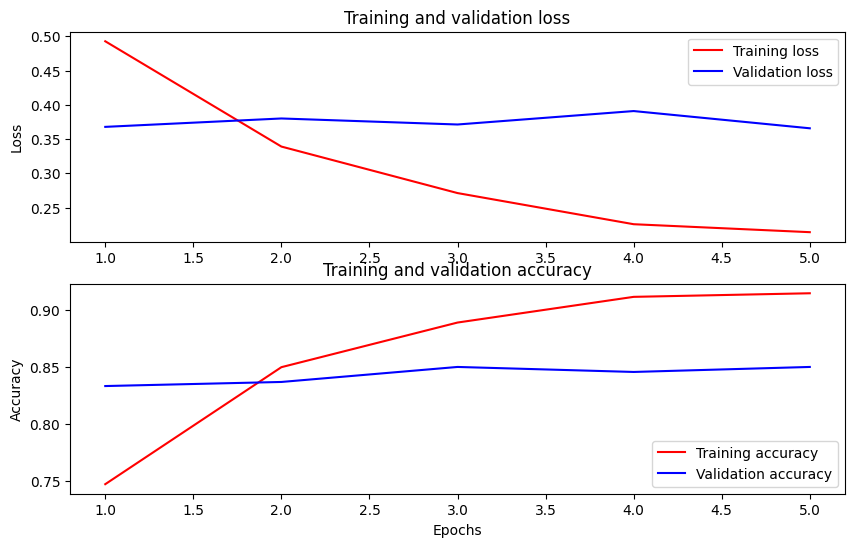

In [21]:
# Extracting training history data
history_dict = history.history
print(history_dict.keys())

# Assigning the training and validation accuracy and loss values to variables
acc = history_dict["binary_accuracy"]
val_acc = history_dict["val_binary_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]

# Defining the range of epochs
epochs = range(1, len(acc) + 1)

# Setting up the figure for plotting
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

# Plotting training and validation loss
plt.subplot(2, 1, 1)
plt.plot(epochs, loss, "r", label="Training loss")  # Red line for training loss
plt.plot(epochs, val_loss, "b", label="Validation loss")  # Blue line for validation loss
plt.title("Training and validation loss")
plt.ylabel("Loss")
plt.legend()

# Plotting training and validation accuracy
plt.subplot(2, 1, 2)
plt.plot(epochs, acc, "r", label="Training accuracy")  # Red line for training accuracy
plt.plot(epochs, val_acc, "b", label="Validation accuracy")  # Blue line for validation accuracy
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

# Display the plots
plt.show()


### Explanation of the Training and Validation Plots

The images represent two important aspects of model training: **loss** and **accuracy** over the course of training epochs.

#### Top Plot: Training and Validation Loss
- **X-axis (Epochs)**: Represents the number of training iterations over the entire dataset. The model is trained for 5 epochs in this case.
- **Y-axis (Loss)**: Represents the loss value, which is a measure of how well the model's predictions match the true labels. Lower loss values indicate better performance.

**Red Line (Training Loss)**:
- The red line shows the loss on the training data. 
- It decreases consistently across epochs, indicating that the model is learning and improving its predictions on the training data.

**Blue Line (Validation Loss)**:
- The blue line shows the loss on the validation data, which is used to evaluate the model's performance on unseen data.
- The validation loss remains relatively stable, slightly decreasing and then plateauing. This suggests that while the model is improving on the training data, its performance on unseen data does not improve significantly after a certain point.

#### Bottom Plot: Training and Validation Accuracy
- **X-axis (Epochs)**: Represents the number of training epochs.
- **Y-axis (Accuracy)**: Represents the accuracy of the model, which is the percentage of correct predictions.

**Red Line (Training Accuracy)**:
- The red line shows the accuracy on the training data.
- It steadily increases across epochs, indicating that the model is getting better at making correct predictions on the training data.

**Blue Line (Validation Accuracy)**:
- The blue line shows the accuracy on the validation data.
- The validation accuracy improves slightly and then remains almost constant, suggesting that the model's ability to generalize to unseen data stabilizes early on and does not improve much after that.

### Interpretation
- **Training Performance**: The model is learning well on the training data, as indicated by the decreasing training loss and increasing training accuracy.
- **Validation Performance**: The relatively flat validation loss and accuracy suggest that the model may have reached its optimal performance on the validation data early in the training process. This can be a sign of a well-trained model, but if the gap between training and validation metrics widens further, it could indicate overfitting.


### Export for inference

Now you just save your fine-tuned model for later use.

Save the model to saved_model_path for inference.

In [25]:
# Set the dataset name
dataset_name = "imdb"

# Define the path to save the model, formatted with the dataset name
saved_model_path = "./{}_bert".format(dataset_name.replace("/", "_"))

# Get the current timestamp in the format YYYYMMDDHHMMSS
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Combine the model path with the timestamp to create a unique export path
EXPORT_PATH = os.path.join(saved_model_path, TIMESTAMP)

# Save the classifier model to the export path, excluding the optimizer to reduce the saved model size
classifier_model.save(EXPORT_PATH, include_optimizer=False)


Let's reload the model so you can try it side by side with the model that is still in memory.

In [26]:
# Reload the saved model from the specified export path
reloaded_model = tf.saved_model.load(EXPORT_PATH)


Here you can test your model on any sentence you want, just add to the examples variable below.

In [27]:
def print_my_examples(inputs, results):
    """
    Prints the inputs and their corresponding results in a formatted manner.

    Args:
        inputs (list): List of input strings.
        results (list): List of results corresponding to each input.
    """
    result_for_printing = [
        f"input: {inputs[i]:<30} : score: {results[i][0]:.6f}"
        for i in range(len(inputs))
    ]
    print(*result_for_printing, sep="\n")
    print()


# Example sentences to test the model
examples = [
    "this is such an amazing movie!",  # Same sentence as used earlier
    "The movie was great!",
    "The movie was meh.",
    "The movie was okish.",
    "The movie was terrible...",
]

# Get predictions from the reloaded model
reloaded_results = reloaded_model(tf.constant(examples))

# Get predictions from the original model in memory
original_results = classifier_model(tf.constant(examples))

# Print results from the saved model
print("Results from the saved model:")
print_my_examples(examples, reloaded_results)

# Print results from the model currently in memory
print("Results from the model in memory:")
print_my_examples(examples, original_results)


Results from the saved model:
input: this is such an amazing movie! : score: 0.997155
input: The movie was great!           : score: 0.983708
input: The movie was meh.             : score: 0.958868
input: The movie was okish.           : score: 0.055479
input: The movie was terrible...      : score: 0.005328

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997155
input: The movie was great!           : score: 0.983708
input: The movie was meh.             : score: 0.958868
input: The movie was okish.           : score: 0.055479
input: The movie was terrible...      : score: 0.005328



## Continued Learning

In this lab, we chose small BERT to train our text classifier. There are other pre-trained BERT models which you can find here. Consider experiementing with some of these. However, remember that the bigger the model you choose to fine-tune, the longer it will take to train.

There are 
  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature.

Aside from the models available above, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yeld even better accuracy but they are too big to be fine-tuned on a single GPU.

#### License

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License